In [2]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np
sns.set_theme()


SEED=0


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [35]:
dataset='DragonFiltered'


In [8]:
data_path = './data/alvaDescDescriptors.txt'
na_values=['na']
df = pd.read_csv(data_path, sep="\t",  dtype={'pctapi': np.float64}, na_values=na_values)
smiles =  np.loadtxt("./data/smiles.txt", dtype='str')
df = df.drop(['No.', 'NAME'], axis=1)
df = df.set_index(smiles)

df = df.loc[:, df.columns.isin(['DLS_cons', 'Hypnotic.80', 'Neoplastic.50', 'DLS_04', 'T(N..O)', 'SpMax3_bh(s)',
       'SpMax2_bh(s)', 'CATS2D_02_DA', 'Eig03_EA(dm)', 'SpPosA_B(p)', 'P_VSA_MR_2', 
       'AMR', 'SM1_Dz(p)', 'SM1_Dz(i)', 'nCconj'])]

data_path = './data/master_4Mayhew.xlsx'
df_mor = pd.read_excel(data_path)
y=df_mor['label'] # labels, independent variables
X=df # features, dependent variables

X.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))


X.describe()

,SM1_Dz(p),SM1_Dz(i),SpPosA_B(p),P_VSA_MR_2,Eig03_EA(dm),nCconj,CATS2D_02_DA,T(N..O),AMR,DLS_04,DLS_cons
count,858.000000,858.000000,858.000000,865.000000,858.000000,865.000000,865.000000,865.000000,860.000000,865.000000,865.000000
mean,-1.047112,0.335124,1.210784,46.413206,0.060258,0.441618,0.320231,3.241618,41.531778,0.696416,0.847699
std,0.670325,0.268824,0.129241,40.391549,0.522990,1.047098,0.875526,12.104794,19.296159,0.249905,0.098993
min,-3.434007,-0.360816,0.753718,0.000000,-4.395737,0.000000,0.000000,0.000000,2.301300,0.100000,0.554762
25%,-1.436726,0.159650,1.156817,23.542204,0.000000,0.000000,0.000000,0.000000,27.809400,0.500000,0.764286
50%,-1.223775,0.297286,1.214748,36.144815,0.000000,0.000000,0.000000,0.000000,39.565250,0.700000,0.857143
75%,-0.788457,0.451967,1.265436,69.457879,0.000000,0.000000,0.000000,0.000000,49.997125,0.900000,0.938095
max,1.087046,1.783694,3.039800,271.313081,2.612452,6.000000,6.000000,160.000000,142.900900,1.000000,1.000000


# Explore the dataset

## How many missing values?

In [10]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")
print(f"\n Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")
print(f"\n Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with all NaNs 
False    11
dtype: int64

 Number of columns with >0.9 NaNs 
False    11
dtype: int64

 Number of columns with a NaN 
5


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

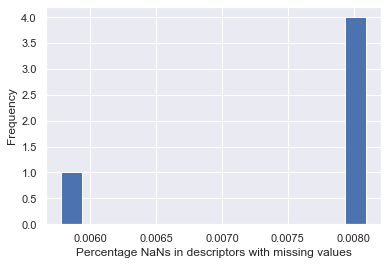

In [11]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

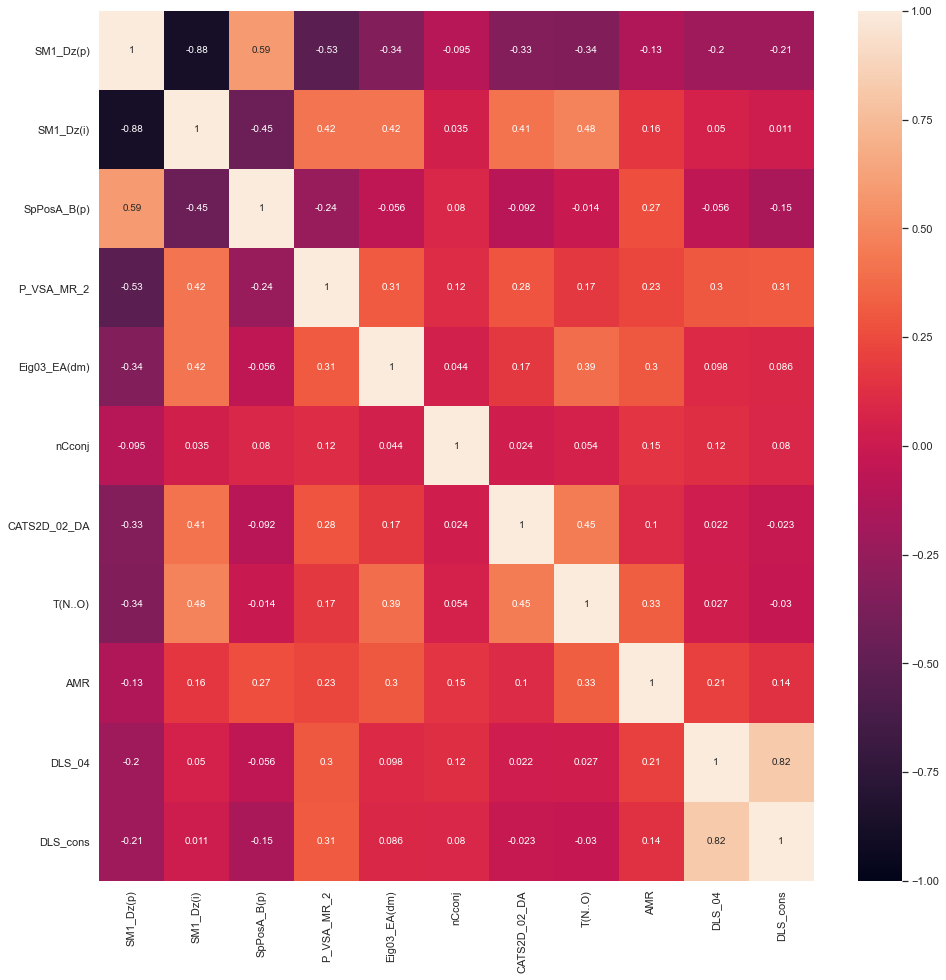

In [14]:
corrs = df.corr()
plt.figure(figsize = (16,16))
heatmap = sns.heatmap(corrs, vmin=-1, vmax=1, annot=True)

In [99]:
corrs.to_csv(f'results/correlations/descriptor-correlations-{dataset}.csv')  

# Preprocessing

In [17]:
# Correlation

corrs = df.corr()
# select upper traingle of correlation matrix
upper = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(bool))
# Find index of columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
# drop the columns
df.drop(to_drop, axis=1, inplace=True)
# Remove descriptors with all NaNs 
df.dropna(axis=1, how='all', inplace=True)
df

,SM1_Dz(p),SM1_Dz(i),SpPosA_B(p),P_VSA_MR_2,Eig03_EA(dm),nCconj,CATS2D_02_DA,T(N..O),AMR,DLS_04,DLS_cons
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,-1.757858,0.526148,1.215730,50.289854,0.367662,2,1,0,43.4446,0.4,0.700000
C(=C(F)F)(C(F)(F)F)C(F)(F)F,-2.898296,1.342760,0.895484,89.760680,1.510000,0,0,0,23.0111,0.7,0.838095
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],-2.415914,1.060322,1.167397,42.683343,2.612452,0,0,71,49.7262,0.4,0.723810
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,-1.165429,0.562583,1.303249,25.144927,0.484748,1,0,5,79.9621,0.6,0.871429
C(C(C(F)(F)F)(F)Cl)(F)Cl,-2.427375,1.109189,1.013713,74.800566,1.534796,0,0,0,26.4845,0.5,0.809524
...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,-1.223775,0.297286,1.161512,71.458121,0.000000,0,0,0,35.9897,1.0,0.952381
C=CCSS(=O)CC=C,-0.346281,-0.000700,1.374833,22.156476,0.000000,0,0,0,46.6775,0.9,0.938095
CCCC(=O)OCC(C)C,-1.223775,0.297286,1.168715,47.915917,0.000000,0,0,0,40.3847,1.0,0.952381
CCCCCOC(=O)CCC,-1.223775,0.297286,1.171368,59.687019,0.000000,0,0,0,45.1149,0.8,0.923810


# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test
percentage_odorless = y_train.value_counts()[False]/y_train.shape[0]
percentage_odor = 1 - percentage_odorless
print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


### Validation set

In [19]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=SEED)

print("Number of training samples:", len(X_train_t))
print("Number of validation samples:", len(X_val))

Number of training samples: 484
Number of validation samples: 208


## More preprocessing

In [20]:
from sklearn import preprocessing 

# Scale dataset 

min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = min_max_scaler.fit_transform(X_train)

X_train =  pd.DataFrame(X_train_transformed, columns=X_train.columns[0:], index=X_train.index)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns[0:], index=X_test.index)

min_max_scaler2 = preprocessing.MinMaxScaler()
X_train_t_transformed = min_max_scaler2.fit_transform(X_train_t)

X_train_t = pd.DataFrame(X_train_t_transformed, columns=X_train_t.columns[0:], index=X_train_t.index)
X_val = pd.DataFrame(min_max_scaler2.transform(X_val), columns=X_val.columns[0:], index=X_val.index)

X_train

,SM1_Dz(p),SM1_Dz(i),SpPosA_B(p),P_VSA_MR_2,Eig03_EA(dm),nCconj,CATS2D_02_DA,T(N..O),AMR,DLS_04,DLS_cons
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.348969,0.471852,0.194461,0.250000,0.627229,0.2,0.166667,0.122449,0.266081,0.333333,0.366120
CCCCCCCCCCCCCCCCO,0.585162,0.242697,0.189155,0.086771,0.627229,0.0,0.000000,0.000000,0.531805,0.111111,0.000000
C1(C(O1)(F)F)(C(F)(F)F)F,0.159728,0.724321,0.057900,0.330838,0.795751,0.0,0.000000,0.000000,0.099486,0.666667,0.737705
CC(C)(C=C)O,0.585162,0.242697,0.190132,0.260314,0.627229,0.0,0.000000,0.000000,0.168510,0.666667,0.792350
C=CCC1=CC2=C(C=C1)OCO2,0.488875,0.306878,0.227742,0.081086,0.703070,0.0,0.000000,0.000000,0.308727,0.777778,0.661202
...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.832890,0.129394,0.229586,0.086771,0.627229,0.0,0.000000,0.000000,0.181235,0.666667,0.573770
CCN(CC)CC,0.655600,0.262960,0.171228,0.390471,0.627229,0.0,0.000000,0.000000,0.223878,0.222222,0.661202
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.585162,0.242697,0.244240,0.092679,0.627229,0.2,0.000000,0.000000,0.383871,0.444444,0.398907
N,0.585162,0.341642,0.207394,0.000000,0.627229,0.0,0.000000,0.000000,0.017957,0.111111,0.191257


# Test Model 

In [21]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred,  digits=4))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs)

In [22]:
def test_model_cross_val(model, y_test, X_test, k=5, verbose=True):
    roc_auc_nans = cross_val_score(model, X_test, y_test, cv=k, scoring='roc_auc')
    print(f"AVERAGE CV={k} ROC_AUC: {np.mean(roc_auc_nans)}")
    print(f"AVERAGE CV={k} STD: {np.std(roc_auc_nans)}")
    return np.mean(roc_auc_nans), np.std(roc_auc_nans)

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [23]:
def handle_importance(model, X_train, X_test=pd.DataFrame(), threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    
    if not X_test.empty:
        X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [41]:
def optimiseImportance(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    
    imp_params = [
              {"threshold":-1, 'n':1},
              {"threshold":-1, 'n':2},
              {"threshold":-1, 'n':3},
              {"threshold":-1, 'n':4},
              {"threshold":-1, 'n':5},
              {"threshold":-1, 'n':6}, 
              {"threshold":-1, 'n':7},
              {"threshold":-1, 'n':8},
              {"threshold":-1, 'n':9},
              {"threshold":-1, 'n':10}, 
              {"threshold":-1, 'n':X_tr.shape[1]}]
    
    sns.set(rc={'figure.figsize':(11.7,12.27)})
    feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
    top_50 = feature_imp.nlargest(50)
    sns.barplot(x=top_50, y=top_50.index)
    plt.xlabel('Descriptor Importance Score')
    plt.ylabel('Descriptor')
    plt.title(f"Top {top_50.shape[-1]} descriptors")
    plt.show()

    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        
        X_tr_temp , _, _ = handle_importance(model, 
                                            X_tr.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
                
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Most important N descriptors", y="Average AUROC", 
                          yerr="Standard Deviation", 
                          figsize=(8,5),
                          title=f"AUROC after filtering descriptors by importance CV={k} - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
    return imp_df

In [45]:
def testWithoutImportantDescs(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    imp_params = [
                  {"threshold":-1, 'n':1},
                  {"threshold":-1, 'n':2},
                  {"threshold":-1, 'n':3},
                  {"threshold":-1, 'n':4},
                  {"threshold":-1, 'n':5},
                  {"threshold":-1, 'n':6}, 
                  {"threshold":-1, 'n':7},
                  {"threshold":-1, 'n':8},
                  {"threshold":-1, 'n':9},
                  {"threshold":-1, 'n':10} ]
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    roc_auc, std = test_model_cross_val(model, y_tr, X_tr)
    imp_df = imp_df.append({'Most important N descriptors': 0, 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

    
    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}")

        feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
        feature_imp = feature_imp.nlargest(imp_param['n'])
        X_tr_temp = X_tr.drop(feature_imp.axes[0].tolist(), axis=1) 
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar",figsize=(8,5), x="Most important N descriptors", y="Average AUROC",  ylabel="Average AUROC",  yerr="Standard Deviation", title=f"AUROC after removing descriptors by importance CV={k}  - {model_name} - {dataset}", legend=False)
        plt.ylim(0,1)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [26]:
from sklearn.impute import KNNImputer

def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            imputer = KNNImputer(n_neighbors=2)
            X_tr_temp = imputer.fit_transform(X_tr)
            X_te_temp = imputer.transform(X_te)
            
            X_tr =  pd.DataFrame(X_tr_temp, columns=X_tr.columns[0:], index=X_tr.index)
            X_te = pd.DataFrame(X_te_temp, columns=X_te.columns[0:], index=X_te.index)
    
    return X_tr, X_te

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [157]:
clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

## Handle NaNs RF

In [158]:
# Handle NaNs in random forest
# impute all missing values, since there aren't many
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.9)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.9)

In [58]:
clf.fit(X_train_rf, y_train_rf)
print("Cross validated = 5 performance of Random Forest after removing all columns with NaNs")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Cross validated = 5 performance of Random Forest after removing all columns with NaNs
AVERAGE CV=5 ROC_AUC: 0.9571737786023501
AVERAGE CV=5 STD: 0.006901991580468326


(0.9571737786023501, 0.006901991580468326)

## Importance experiment

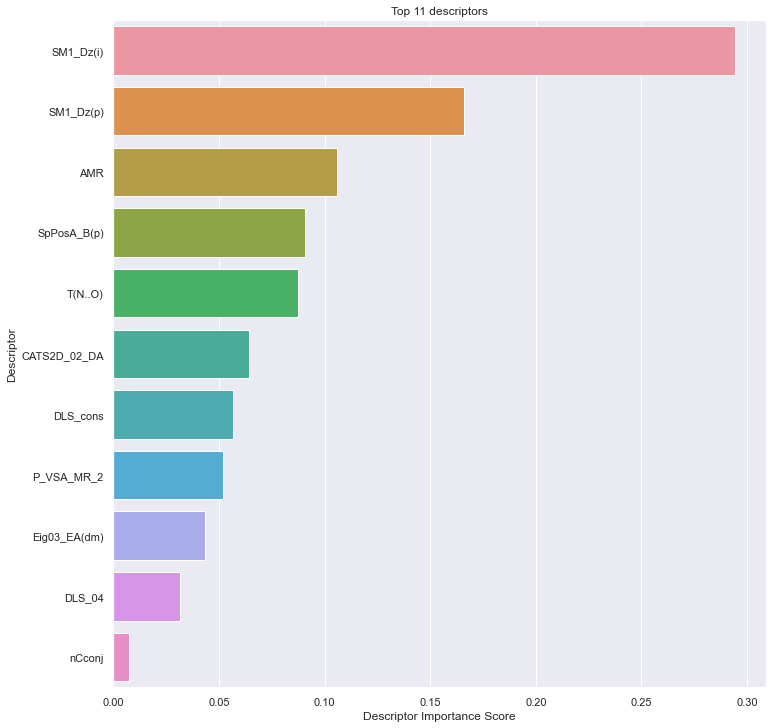

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.908699,0.024359
1,2.0,0.916386,0.017809
2,3.0,0.936247,0.014381
3,4.0,0.947512,0.009238
4,5.0,0.947117,0.008425
5,6.0,0.946399,0.012438
6,7.0,0.953547,0.005921
7,8.0,0.962443,0.002193
8,9.0,0.957012,0.005289
9,10.0,0.960828,0.004135


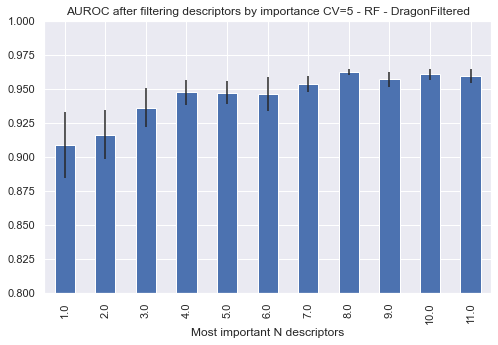

In [43]:
clf.fit(X_train_rf, y_train_rf)
optimiseImportance(clf, X_train_rf, y_train_rf)

AVERAGE CV=5 ROC_AUC: 0.9571737786023501
AVERAGE CV=5 STD: 0.006901991580468326


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.957174,0.006902
1,1.0,0.948979,0.008565
2,2.0,0.949072,0.018865
3,3.0,0.944965,0.015019
4,4.0,0.909235,0.015028
5,5.0,0.893667,0.015384
6,6.0,0.872730,0.025599
7,7.0,0.855267,0.029002
8,8.0,0.774779,0.028378
9,9.0,0.656094,0.055701


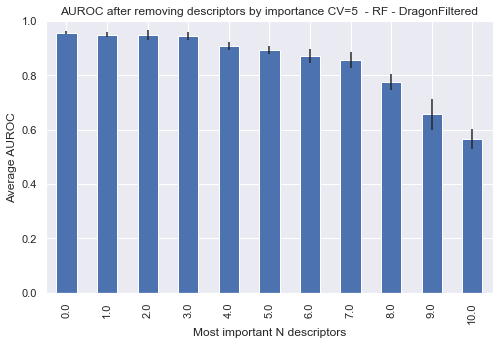

In [46]:
clf.fit(X_train_rf, y_train_rf)
testWithoutImportantDescs(clf, X_train_rf, y_train_rf)

In [159]:
# Filter labels by importance
clf.fit(X_train_rf, y_train_rf)
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=8)

In [60]:
clf.fit(X_train_rf, y_train_rf)
print("Cross validated training set performance of Random Forest after removing labels")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Cross validated training set performance of Random Forest after removing labels
AVERAGE CV=5 ROC_AUC: 0.9624427952999381
AVERAGE CV=5 STD: 0.002192808168398926


(0.9624427952999381, 0.002192808168398926)

In [61]:
X_train_rf

,SM1_Dz(i),SM1_Dz(p),AMR,SpPosA_B(p),T(N..O),CATS2D_02_DA,DLS_cons,P_VSA_MR_2
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.471852,0.348969,0.266081,0.194461,0.122449,0.166667,0.366120,0.250000
CCCCCCCCCCCCCCCCO,0.242697,0.585162,0.531805,0.189155,0.000000,0.000000,0.000000,0.086771
C1(C(O1)(F)F)(C(F)(F)F)F,0.724321,0.159728,0.099486,0.057900,0.000000,0.000000,0.737705,0.330838
CC(C)(C=C)O,0.242697,0.585162,0.168510,0.190132,0.000000,0.000000,0.792350,0.260314
C=CCC1=CC2=C(C=C1)OCO2,0.306878,0.488875,0.308727,0.227742,0.000000,0.000000,0.661202,0.081086
...,...,...,...,...,...,...,...,...
CCCCS,0.129394,0.832890,0.181235,0.229586,0.000000,0.000000,0.573770,0.086771
CCN(CC)CC,0.262960,0.655600,0.223878,0.171228,0.000000,0.000000,0.661202,0.390471
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.242697,0.585162,0.383871,0.244240,0.000000,0.000000,0.398907,0.092679
N,0.341642,0.585162,0.017957,0.207394,0.000000,0.000000,0.191257,0.000000


## Tuning the hyperparamaters 

In [62]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [63]:
params = {
    'n_estimators': (10, 2000),
    'min_samples_split': (1, 100),
    'max_depth': (3,200),
    'min_samples_leaf': (1, 10)
    }

def rf_hyper_param(n_estimators, 
                       min_samples_split, 
                       max_depth, 
                       min_samples_leaf):

    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    min_samples_split = int(min_samples_split)
    n_estimators = int(n_estimators)

    rf_temp = RandomForestClassifier(
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(rf_temp, X_train_rf, y_train_rf, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=rf_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9522    | 111.1     | 7.437     | 60.67     | 1.094e+03 |
| 2         | 0.9538    | 86.46     | 6.813     | 44.32     | 1.785e+03 |
| 3         | 0.952     | 192.8     | 4.451     | 79.38     | 1.063e+03 |
| 4         | 0.9541    | 114.9     | 9.33      | 8.033     | 183.4     |
| 5         | 0.9518    | 6.983     | 8.494     | 78.04     | 1.741e+03 |
| 6         | 0.9564    | 113.8     | 7.378     | 3.534     | 173.1     |
| 7         | 0.9621    | 116.6     | 2.516     | 6.523     | 171.7     |
| 8         | 0.9587    | 120.5     | 4.794     | 13.94     | 170.5     |
| 9         | 0.9595    | 118.4     | 5.86      | 3.813     | 165.7     |
| 10        | 0.9601    | 107.7     | 2.924     | 16.8      | 170.9     |
| 11        | 0.9575    | 112.4     | 4.442     | 19.0      | 162.8     |
| 12        | 0.9557    | 98.67     | 

In [64]:
params_tuned_rf = optimizer.max['params']
params_tuned_rf['max_depth'] = int(params_tuned_rf['max_depth'])
params_tuned_rf['n_estimators'] = int(params_tuned_rf['n_estimators'])
params_tuned_rf['min_samples_leaf'] = int(params_tuned_rf['min_samples_leaf'])
params_tuned_rf['min_samples_split'] = int(params_tuned_rf['min_samples_split'])

tuned_rf = RandomForestClassifier(**params_tuned_rf, random_state=SEED)
test_model_cross_val(tuned_rf, y_train_rf, X_train_rf, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9641715625644197
AVERAGE CV=5 STD: 0.0035168003953330693


(0.9641715625644197, 0.0035168003953330693)

In [65]:
print(params_tuned_rf)

{'max_depth': 75, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 163}


In [161]:
# Run me if you want the tuned model without running training

clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

# Handle NaNs
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.9)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.9)

# Fit model 
clf.fit(X_train_rf, y_train_rf)

# Handle features 
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=8)

# Create tuned model
params_tuned_rf_saved = {'max_depth': 116, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 171}
tuned_rf = RandomForestClassifier(**params_tuned_rf_saved, random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=116, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=171, random_state=0)

ROC_AUC (TEST): 0.9791869918699188


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False     0.8627    0.8800    0.8713        50
        True     0.9508    0.9431    0.9469       123

    accuracy                         0.9249       173
   macro avg     0.9068    0.9115    0.9091       173
weighted avg     0.9254    0.9249    0.9251       173



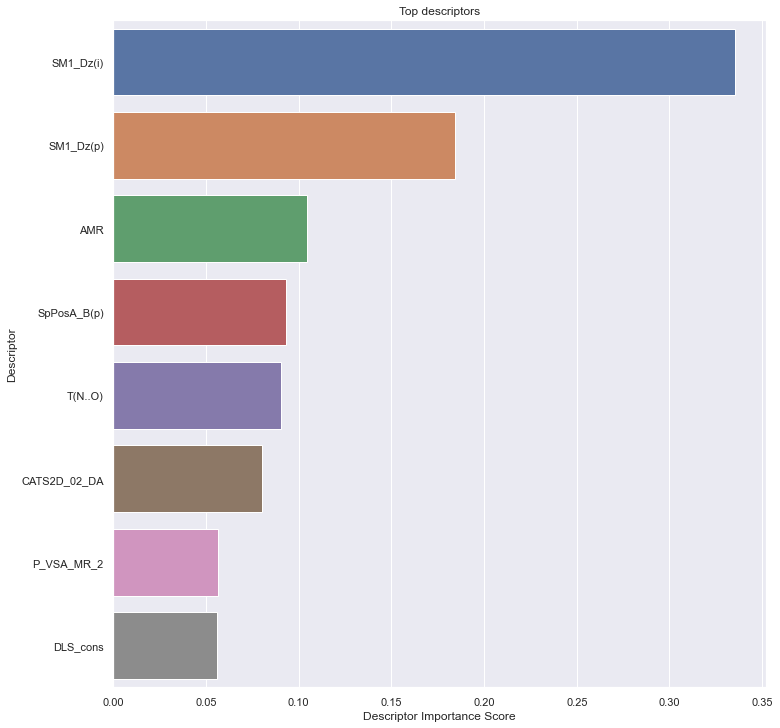

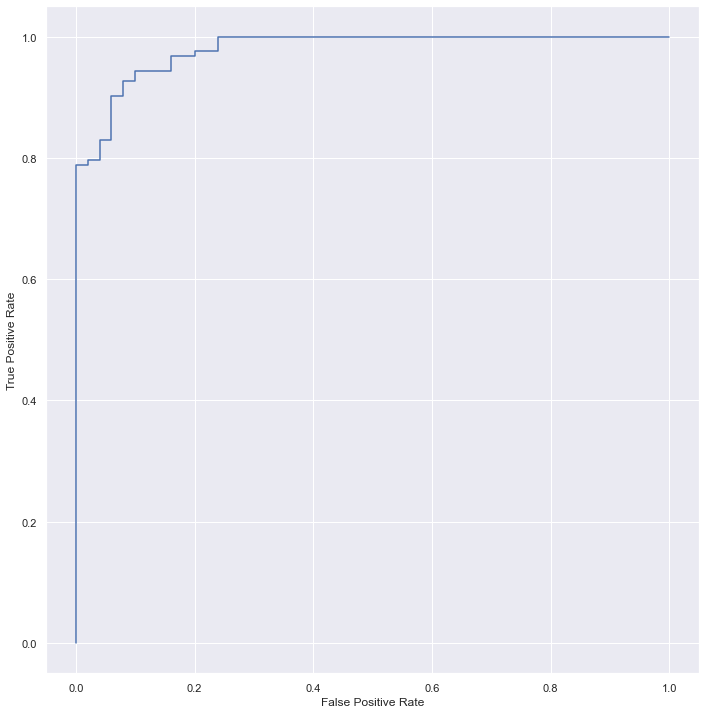

0.9791869918699188

In [67]:
tuned_rf.fit(X_train_rf, y_train_rf)
test_model(tuned_rf, y_test_rf, X_test_rf)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [68]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv(f'data/random-forest-df-{dataset}.csv')  
rf_csv

,SM1_Dz(i),SM1_Dz(p),AMR,SpPosA_B(p),T(N..O),CATS2D_02_DA,DLS_cons,P_VSA_MR_2
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.526148,-1.757858,43.4446,1.215730,0,1,0.700000,50.289854
C(=C(F)F)(C(F)(F)F)C(F)(F)F,1.342760,-2.898296,23.0111,0.895484,0,0,0.838095,89.760680
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.060322,-2.415914,49.7262,1.167397,71,0,0.723810,42.683343
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.562583,-1.165429,79.9621,1.303249,5,0,0.871429,25.144927
C(C(C(F)(F)F)(F)Cl)(F)Cl,1.109189,-2.427375,26.4845,1.013713,0,0,0.809524,74.800566
...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.297286,-1.223775,35.9897,1.161512,0,0,0.952381,71.458121
C=CCSS(=O)CC=C,-0.000700,-0.346281,46.6775,1.374833,0,0,0.938095,22.156476
CCCC(=O)OCC(C)C,0.297286,-1.223775,40.3847,1.168715,0,0,0.952381,47.915917
CCCCCOC(=O)CCC,0.297286,-1.223775,45.1149,1.171368,0,0,0.923810,59.687019


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [69]:
# for readibility 
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

## Create model

In [70]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [71]:
# Baseline results
print("Baseline performance of XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Baseline performance of XGBoost
AVERAGE CV=5 ROC_AUC: 0.9515530303030303
AVERAGE CV=5 STD: 0.006778740339976748


(0.9515530303030303, 0.006778740339976748)

## Handle NaNs

In [73]:
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.9)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.9)

In [75]:
# Imputing missing values rather than leaving in achieves better results
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9558598742527314
AVERAGE CV=5 STD: 0.0074389557478830234


(0.9558598742527314, 0.0074389557478830234)

## Importance Experiment XGB

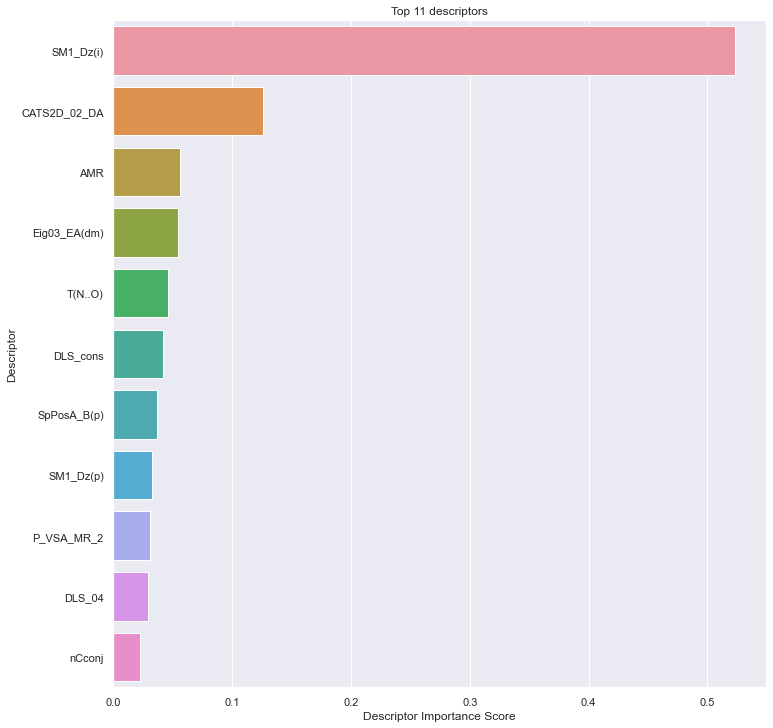

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.915170,0.019633
1,2.0,0.922486,0.023415
2,3.0,0.934701,0.014250
3,4.0,0.936705,0.012273
4,5.0,0.937266,0.010389
5,6.0,0.934865,0.011560
6,7.0,0.947350,0.007762
7,8.0,0.953239,0.007302
8,9.0,0.951977,0.010200
9,10.0,0.956182,0.007390


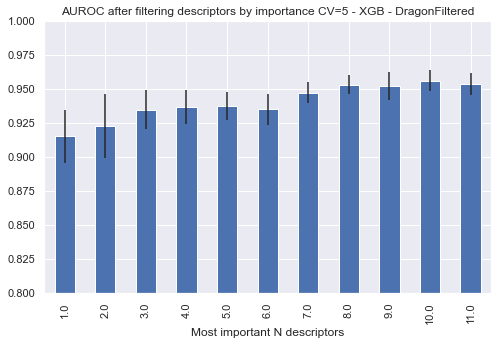

In [76]:
xgb.fit(X_train_xgb, y_train_xgb)
optimiseImportance(xgb, X_train_xgb, y_train_xgb, model_name="XGB")

AVERAGE CV=5 ROC_AUC: 0.9558598742527314
AVERAGE CV=5 STD: 0.0074389557478830234


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.955860,0.007439
1,1.0,0.943807,0.006259
2,2.0,0.940196,0.009686
3,3.0,0.945530,0.008671
4,4.0,0.942342,0.011062
5,5.0,0.937060,0.014028
6,6.0,0.926044,0.012957
7,7.0,0.922451,0.023741
8,8.0,0.833724,0.027625
9,9.0,0.656723,0.060164


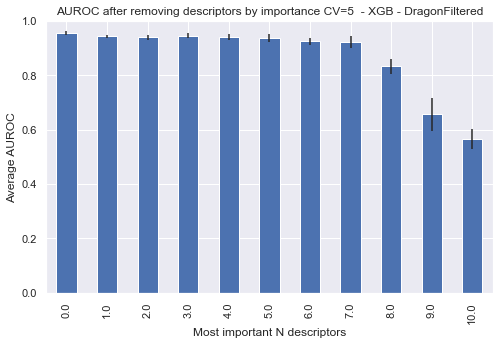

In [77]:
xgb.fit(X_train_xgb, y_train_xgb)
testWithoutImportantDescs(xgb, X_train_xgb, y_train_xgb, model_name="XGB")

In [78]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test=X_test_xgb, 
                                                threshold=-1, 
                                                n=10)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_test=X_val_xgb, 
                                                threshold=-1, 
                                                n=10)
xgb.fit(X_train_t_xgb, y_train_t)

# Filted importance results
print("Cross validated CV=5 performance after filtering by importance XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Cross validated CV=5 performance after filtering by importance XGBoost
AVERAGE CV=5 ROC_AUC: 0.9561819727891157
AVERAGE CV=5 STD: 0.007390107543438477


(0.9561819727891157, 0.007390107543438477)

In [79]:
X_train_xgb

,SM1_Dz(i),CATS2D_02_DA,AMR,Eig03_EA(dm),T(N..O),DLS_cons,SpPosA_B(p),SM1_Dz(p),P_VSA_MR_2,DLS_04
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.471852,0.166667,0.266081,0.627229,0.122449,0.366120,0.194461,0.348969,0.250000,0.333333
CCCCCCCCCCCCCCCCO,0.242697,0.000000,0.531805,0.627229,0.000000,0.000000,0.189155,0.585162,0.086771,0.111111
C1(C(O1)(F)F)(C(F)(F)F)F,0.724321,0.000000,0.099486,0.795751,0.000000,0.737705,0.057900,0.159728,0.330838,0.666667
CC(C)(C=C)O,0.242697,0.000000,0.168510,0.627229,0.000000,0.792350,0.190132,0.585162,0.260314,0.666667
C=CCC1=CC2=C(C=C1)OCO2,0.306878,0.000000,0.308727,0.703070,0.000000,0.661202,0.227742,0.488875,0.081086,0.777778
...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.129394,0.000000,0.181235,0.627229,0.000000,0.573770,0.229586,0.832890,0.086771,0.666667
CCN(CC)CC,0.262960,0.000000,0.223878,0.627229,0.000000,0.661202,0.171228,0.655600,0.390471,0.222222
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.242697,0.000000,0.383871,0.627229,0.000000,0.398907,0.244240,0.585162,0.092679,0.444444
N,0.341642,0.000000,0.017957,0.627229,0.000000,0.191257,0.207394,0.585162,0.000000,0.111111


## Tuning paramaters 

In [80]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#    'subsample': (0.7, 1.0),  # Change for big datasets
    'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'reg_lambda': (0, 2),
    'reg_alpha':(0, 2),
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        colsample_bytree,
                        gamma, 
                        reg_lambda, 
                        reg_alpha,
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda, 
        reg_alpha=reg_alpha,
        scale_pos_weight=scale_pos_weight,
        seed=SEED)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_xgb, y_train_xgb, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | scale_... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9503    | 0.8646    | 3.576     | 0.6067    | 6.814     | 481.3     | 1.292     | 0.8752    | 2.338     |
| 2         | 0.9522    | 0.9891    | 1.917     | 0.7938    | 6.702     | 611.2     | 1.851     | 0.1421    | 1.131     |
| 3         | 0.9489    | 0.7061    | 4.163     | 0.7804    | 9.09      | 980.8     | 1.598     | 0.923     | 2.171     |
| 4         | 0.9593    | 0.7355    | 3.2       | 0.1519    | 9.613     | 569.7     | 0.8293    | 0.5291    | 2.161     |
| 5         | 0.9577    | 0.8368    | 2.842     | 0.0286    | 7.323     | 650.9     | 1.234     | 1.887     | 2.023     |
| 6         | 0.9558    | 0.9245    | 4.506     | 0.1645    | 9.11      | 569.6     | 0.5934    | 0.02827   | 2.255     |
| 7         | 0.9457    

| 41        | 0.9619    | 0.8248    | 0.073     | 0.1606    | 4.336     | 648.7     | 1.91      | 1.684     | 2.104     |
| 42        | 0.9432    | 0.8576    | 0.09857   | 0.9031    | 4.711     | 649.3     | 1.563     | 0.9426    | 1.412     |
| 43        | 0.9617    | 0.7557    | 1.219     | 0.02652   | 5.04      | 647.0     | 1.842     | 1.097     | 2.238     |
| 44        | 0.9632    | 0.7998    | 0.4464    | 0.01      | 4.832     | 647.8     | 2.0       | 1.62      | 2.379     |
| 45        | 0.9569    | 0.9278    | 0.02714   | 0.5115    | 7.519     | 650.1     | 1.915     | 1.694     | 1.406     |
| 46        | 0.9574    | 0.8527    | 1.221     | 0.4758    | 4.584     | 647.3     | 1.955     | 1.83      | 2.0       |
| 47        | 0.9574    | 0.9128    | 0.2902    | 0.1332    | 5.783     | 647.3     | 1.359     | 0.932     | 2.326     |
| 48        | 0.9573    | 0.7785    | 2.5       | 0.382     | 9.537     | 650.3     | 1.63      | 0.02706   | 2.091     |
| 49        | 0.9612    

In [81]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

{'colsample_bytree': 0.7333695437300213, 'gamma': 0.9902553925469809, 'learning_rate': 0.1362814529149798, 'max_depth': 7, 'n_estimators': 650, 'reg_alpha': 1.7440632911781833, 'reg_lambda': 1.313743480031632, 'scale_pos_weight': 1.0461027548267379}
AVERAGE CV=5 ROC_AUC: 0.9646188930117502
AVERAGE CV=5 STD: 0.006589821547765085


(0.9646188930117502, 0.006589821547765085)

### Final tuned paramaters


In [82]:
# Run me if you want the tuned model without running training

# for readibility 
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

# Handle NaNs
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.9)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.9)

# Fit model 
xgb.fit(X_train_xgb, y_train_xgb)

# Handle features 
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test=X_test_xgb, 
                                                threshold=-1, 
                                                n=10)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_test=X_val_xgb, 
                                                threshold=-1, 
                                                n=10)
xgb.fit(X_train_xgb, y_train_xgb)

# Create tuned model
params_tuned_xgb_saved = {'colsample_bytree': 0.7333695437300213, 'gamma': 0.9902553925469809, 'learning_rate': 0.1362814529149798, 'max_depth': 7, 'n_estimators': 650, 'reg_alpha': 1.7440632911781833, 'reg_lambda': 1.313743480031632, 'scale_pos_weight': 1.0461027548267379}
tuned_xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7333695437300213, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9902553925469809, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1362814529149798, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=650, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [83]:
print("Final tuned CV performance for XGB")
tuned_xgb.fit(X_train_xgb, y_train)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Final tuned CV performance for XGB
AVERAGE CV=5 ROC_AUC: 0.9646188930117502
AVERAGE CV=5 STD: 0.006589821547765085


(0.9646188930117502, 0.006589821547765085)

ROC_AUC (TEST): 0.9785365853658536


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False     0.8600    0.8600    0.8600        50
        True     0.9431    0.9431    0.9431       123

    accuracy                         0.9191       173
   macro avg     0.9015    0.9015    0.9015       173
weighted avg     0.9191    0.9191    0.9191       173



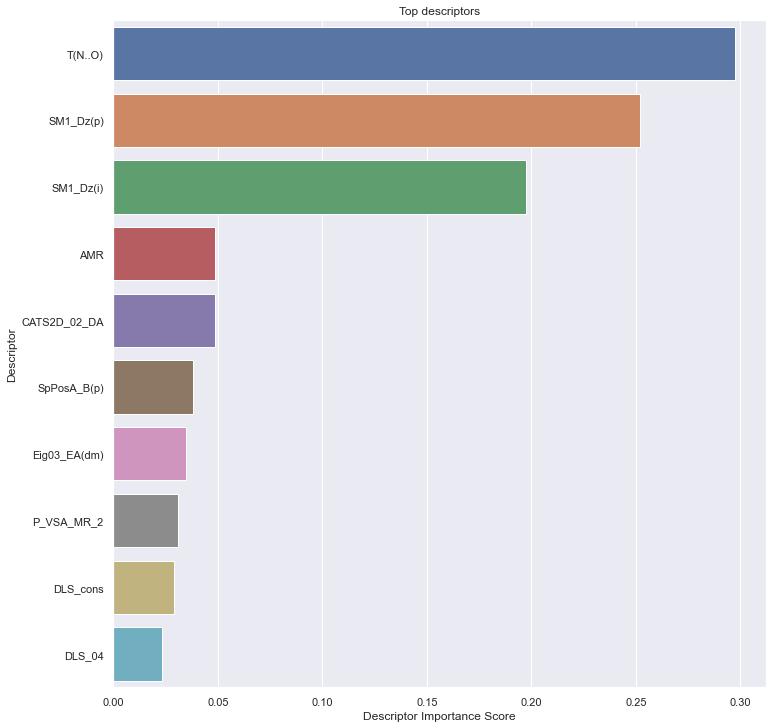

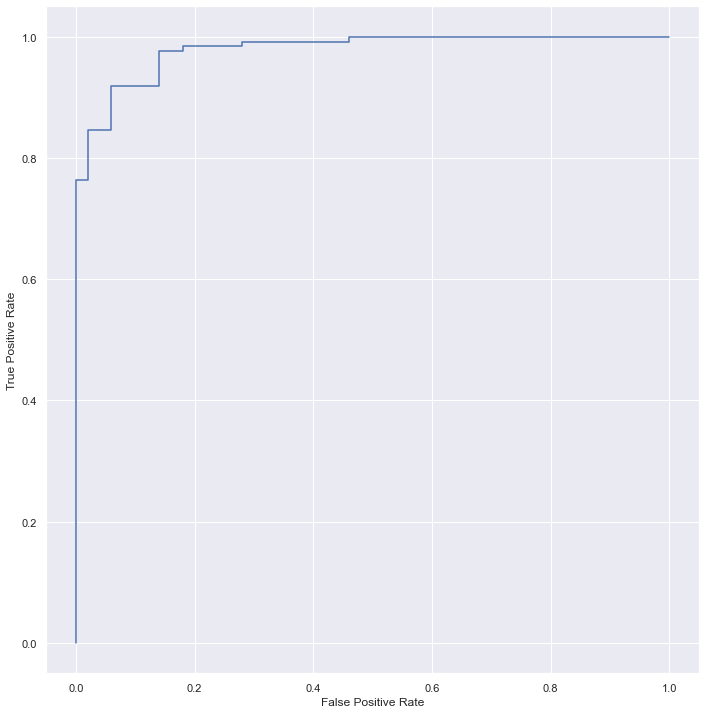

0.9785365853658536

In [84]:
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Save dataframe used in XGB to CSV

In [85]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv(f'data/xgb-df-{dataset}.csv')  
rf_csv

,SM1_Dz(i),CATS2D_02_DA,AMR,Eig03_EA(dm),T(N..O),DLS_cons,SpPosA_B(p),SM1_Dz(p),P_VSA_MR_2,DLS_04
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.526148,1,43.4446,0.367662,0,0.700000,1.215730,-1.757858,50.289854,0.4
C(=C(F)F)(C(F)(F)F)C(F)(F)F,1.342760,0,23.0111,1.510000,0,0.838095,0.895484,-2.898296,89.760680,0.7
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.060322,0,49.7262,2.612452,71,0.723810,1.167397,-2.415914,42.683343,0.4
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.562583,0,79.9621,0.484748,5,0.871429,1.303249,-1.165429,25.144927,0.6
C(C(C(F)(F)F)(F)Cl)(F)Cl,1.109189,0,26.4845,1.534796,0,0.809524,1.013713,-2.427375,74.800566,0.5
...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.297286,0,35.9897,0.000000,0,0.952381,1.161512,-1.223775,71.458121,1.0
C=CCSS(=O)CC=C,-0.000700,0,46.6775,0.000000,0,0.938095,1.374833,-0.346281,22.156476,0.9
CCCC(=O)OCC(C)C,0.297286,0,40.3847,0.000000,0,0.952381,1.168715,-1.223775,47.915917,1.0
CCCCCOC(=O)CCC,0.297286,0,45.1149,0.000000,0,0.923810,1.171368,-1.223775,59.687019,0.8


# Keras

https://www.pluralsight.com/guides/classification-keras

In [86]:
!pip install keras
!pip install scikeras

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# for readibility 
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()
y_train_t_nn, y_val_nn = y_train_t.copy(), y_val.copy()

tf.random.set_seed(SEED)


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Preprocessing

### Handle NaNs 
- You can't have missing values in a Neural Network, so we choose to use the optimal value for XGB

In [87]:
X_train_nn, X_test_nn = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.9)
X_train_t_nn, X_val_nn = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.9)

### Encode class values as integers

In [88]:
encoder = LabelEncoder()
encoder.fit(y_train_t_nn)
y_train_nn = encoder.transform(y_train_nn)
y_train_t_nn = encoder.transform(y_train_t_nn)
y_test_nn = encoder.transform(y_test_nn)
y_val_nn = encoder.transform(y_val_nn)

## Early stopping

In [89]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
# Patience = 3 because we wait for 3 epochs without any improvement 
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=15)

## Metrics

In [90]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc', curve='ROC'),
]

## Test model - Keras

In [91]:
def test_model_keras_train(model, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn): 
    # Plot training and validation auc 

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_auc')
    plt.ylabel('ROC_AUC')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # Plot training and validation ROC curve
    y_pred_keras = model.predict(X_val_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_nn, y_pred_keras)
    auc_v_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)

    # Use the Keras model to make predictions on a test dataset
    y_pred_t_keras = model.predict(X_train_nn)
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_train_nn, y_pred_t_keras)
    
    plt.plot(fpr_keras, tpr_keras)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Validation (area = {:.4f})'.format(auc_v_keras), 'Training (area = {:.3f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()
    
    # Print classification report 
    y_pred = model.predict(X_val_nn).round()
    print(metrics.classification_report(y_val_nn, y_pred, digits=4))


In [92]:
def test_model_keras(model, X_test_nn, y_test_nn, X_train_nn, y_train_nn):
    y_pred_t_keras = model.predict(X_test_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)
    auc_t_keras

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Test (area = {:.4f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()
    
    # Print classification report 
    y_pred = model.predict(X_test_nn).round()
    print(metrics.classification_report(y_test_nn, y_pred, digits=4))

## Baseline Single Layer model
- Overfitting quite a bit, you can see it when you compare the validation set auc and the auc for the training set 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 12)                144       
                                                                 
 dense_23 (Dense)            (None, 1)                 13        
                                                                 
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


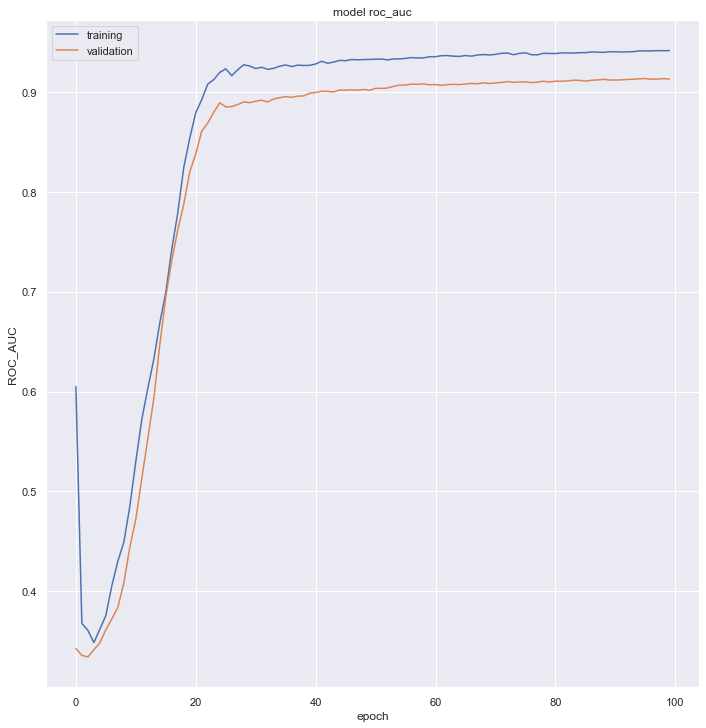

16/16 [==============================] - 0s 1ms/step


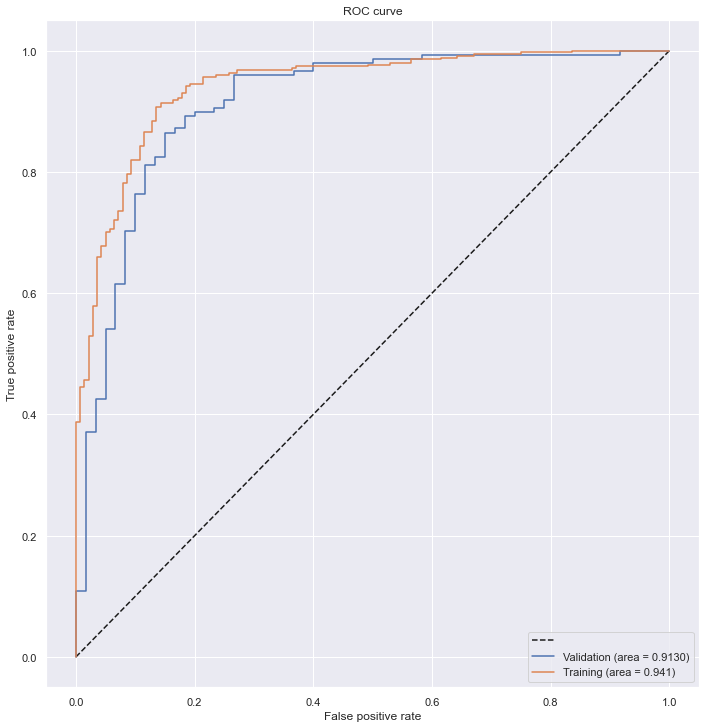

7/7 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.8696    0.6667    0.7547        60
           1     0.8765    0.9595    0.9161       148

    accuracy                         0.8750       208
   macro avg     0.8731    0.8131    0.8354       208
weighted avg     0.8745    0.8750    0.8696       208



In [154]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train_nn.shape[-1]+1, activation="relu", input_shape=(X_train_nn.shape[-1],)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=100, 
                      validation_data=(X_val_nn, y_val_nn), 
                      callbacks=[early_stopping],
                      verbose=0)

test_model_keras_train(model, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

6/6 [==============================] - 0s 1ms/step


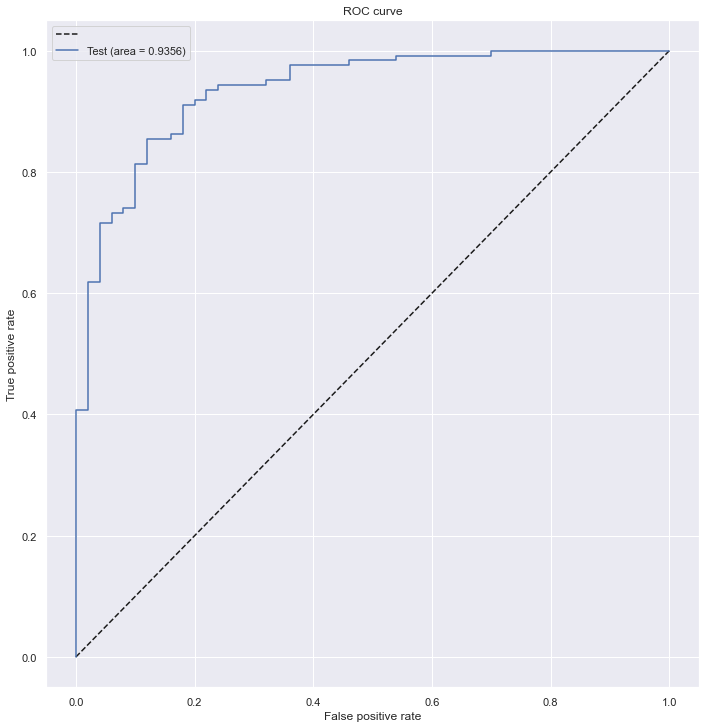

6/6 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9231    0.4800    0.6316        50
           1     0.8231    0.9837    0.8963       123

    accuracy                         0.8382       173
   macro avg     0.8731    0.7319    0.7639       173
weighted avg     0.8520    0.8382    0.8198       173



In [164]:
test_model_keras(model, X_test_nn, y_test_nn, X_train_t_nn, y_train_t_nn)
model_nn1 = model

## Multi Layer Model

### Retune and retrain model

In [132]:
def model_builder_3(hp):

    model = keras.Sequential()
    model.add(Dense(X_train_nn.shape[-1], input_shape=(X_train_nn.shape[-1],), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=1000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=1000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

In [133]:
print(X_val_nn.shape)
tuner = kt.Hyperband(model_builder_3,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=100,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir_dragon",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=100,
             callbacks=[early_stopping],
             validation_data=(X_val_nn, y_val_nn))

Trial 254 Complete [00h 00m 15s]
val_auc: 0.9386823773384094

Best val_auc So Far: 0.956024706363678
Total elapsed time: 00h 17m 13s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [134]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 932 
 The optimal number of units in the second densely-connected
layer is 672 
 The optimal number of dropouts in the first densely-connected
layer is 0.4.
 The optimal learning 
rate is  0.01



In [143]:
model4 = tuner.hypermodel.build(best_hps)
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 11)                132       
                                                                 
 dense_13 (Dense)            (None, 932)               11184     
                                                                 
 dropout_3 (Dropout)         (None, 932)               0         
                                                                 
 dense_14 (Dense)            (None, 672)               626976    
                                                                 
 dense_15 (Dense)            (None, 1)                 673       
                                                                 
Total params: 638,965
Trainable params: 638,965
Non-trainable params: 0
_________________________________________________________________


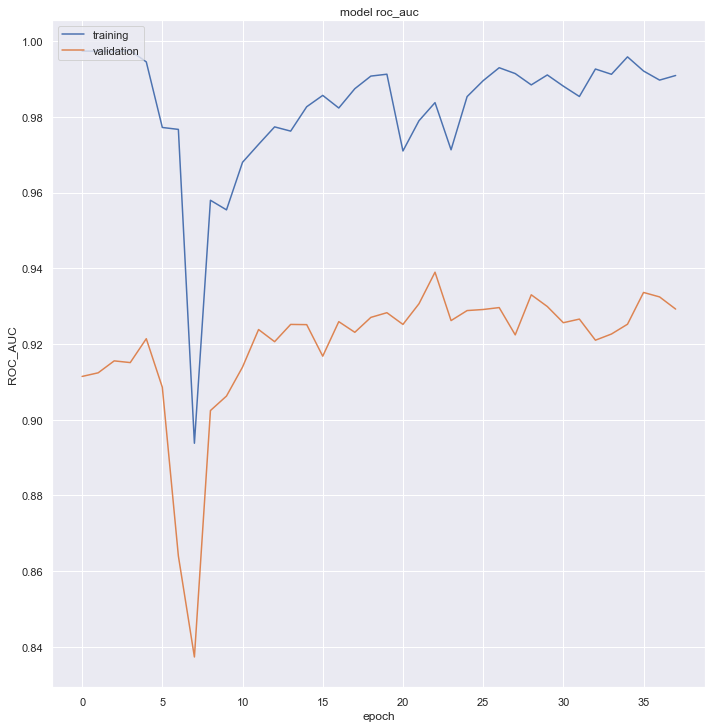

22/22 [==============================] - 0s 2ms/step


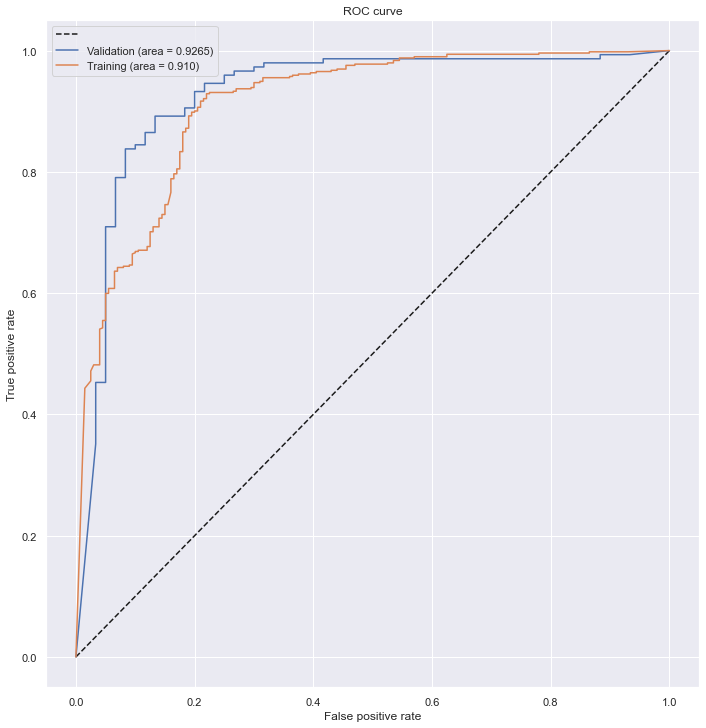

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8276    0.8000    0.8136        60
           1     0.9200    0.9324    0.9262       148

    accuracy                         0.8942       208
   macro avg     0.8738    0.8662    0.8699       208
weighted avg     0.8933    0.8942    0.8937       208



In [170]:
history = model4.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=100,
                      callbacks=[early_stopping],
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras_train(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

In [171]:
tuned_nn = model4

## Evaluate model on test data

6/6 [==============================] - 0s 2ms/step


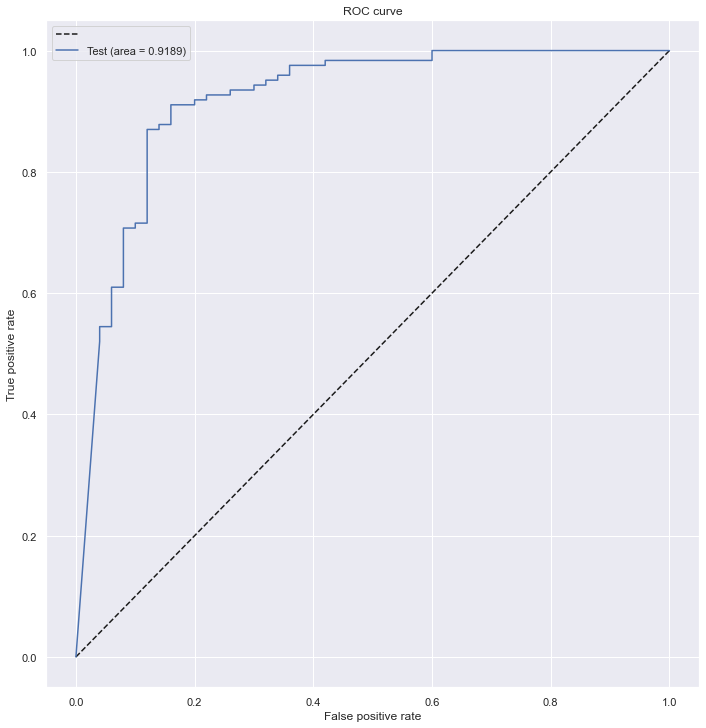

6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9143    0.6400    0.7529        50
           1     0.8696    0.9756    0.9195       123

    accuracy                         0.8786       173
   macro avg     0.8919    0.8078    0.8362       173
weighted avg     0.8825    0.8786    0.8714       173



In [172]:
test_model_keras(model4, X_test_nn, y_test_nn, X_train_nn, y_train_nn)

## Neural net with 3 hidden layers

In [175]:
def model_builder_4(hp):

    model = keras.Sequential()
    model.add(Dense(X_train_nn.shape[-1], input_shape=(X_train_nn.shape[-1],), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=1000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=1000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_3', min_value=2, max_value=1000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

tuner = kt.Hyperband(model_builder_4,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=100,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir_dragon",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=100,
             callbacks=[early_stopping],
             validation_data=(X_val_nn, y_val_nn))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuned_nn3 = tuner.hypermodel.build(best_hps)
tuned_nn3.summary()

Trial 254 Complete [00h 00m 13s]
val_auc: 0.9450450539588928

Best val_auc So Far: 0.9533783197402954
Total elapsed time: 00h 18m 36s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 11)                132       
                                                                 
 dense_6 (Dense)             (None, 62)                744       
                                                                 
 dropout_1 (Dropout)         (None, 62)                0         
                                                                 
 dense_7 (Dense)             (None, 702)               44226     
                                                                 
 dense_8 (Dense)             (None, 62)                43586     
                                                                 
 dense_9 (Dense)             (None, 1)                 63        
                                                                 
Total params: 88,751
Trainable params: 88,751
Non-trai

# Penalized SVM

In [ ]:
from sklearn import svm

y_train_svm = y_train.copy()
y_test_svm = y_test.copy()
X_train_svm, X_test_svm = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [ ]:
clf_s = svm.SVC(kernel='linear',
                gamma='scale',
                class_weight='balanced', # penalize
                probability=True)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

print("Baseline CV=10 training performance of a SVM")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_svm, y_train_svm, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
print("CV=5 training performance of a SVM with RF most important descriptors")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_rf, y_train_rf, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
clf_s.fit(X_train_rf, y_train_rf)
test_model(clf_s, y_test_rf, X_test_rf)

# Graphs for all models

In [165]:
# RF
y_pred_rf=tuned_rf.predict(X_test_rf)
y_pred_probs_rf=tuned_rf.predict_proba(X_test_rf)[:,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  y_pred_probs_rf)  
auc_t_rf = metrics.roc_auc_score(y_test, y_pred_probs_rf)

# XGB
y_pred_xgb=tuned_xgb.predict(X_test_xgb)
y_pred_probs_xgb=tuned_xgb.predict_proba(X_test_xgb)[:,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  y_pred_probs_xgb) 
auc_t_xgb = metrics.roc_auc_score(y_test, y_pred_probs_xgb)


# Neural network 1
y_pred_t_nn1 = model_nn1.predict(X_test_nn).ravel()
fpr_nn1, tpr_nn1, thresholds_nn1 = roc_curve(y_test_nn, y_pred_t_nn1)
auc_t_nn1 = metrics.roc_auc_score(y_test_nn, y_pred_t_nn1)

# Neural network 2
y_pred_t_keras = tuned_nn.predict(X_test_nn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)

6/6 [==============================] - 0s 2ms/step


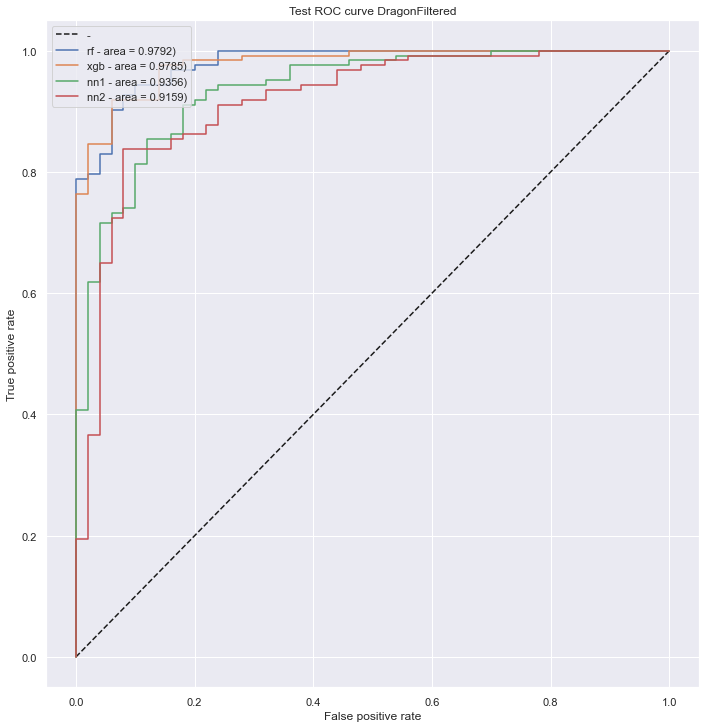

In [173]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf,tpr_rf)
plt.plot(fpr_xgb,tpr_xgb)
plt.plot(fpr_nn1, tpr_nn1)
plt.plot(fpr_keras, tpr_keras)
plt.title(f'Test ROC curve {dataset}')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend(['-', 'rf - area = {:.4f})'.format(auc_t_rf), 'xgb - area = {:.4f})'.format(auc_t_xgb), 'nn1 - area = {:.4f})'.format(auc_t_nn1), 'nn2 - area = {:.4f})'.format(auc_t_keras)], loc='upper left')
plt.show()